# Character Prediction

## Exploratory Data Analysis and Feature Engeneering

In [1]:
# Package imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import nltk
from nltk.corpus import stopwords, sentiwordnet
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import spacy

from typing import List



import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim
import tqdm



import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marcu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
train_df = pd.read_csv('train_df.csv')
val_df = pd.read_csv('val_df.csv')
test_df = pd.read_csv('test_df.csv')


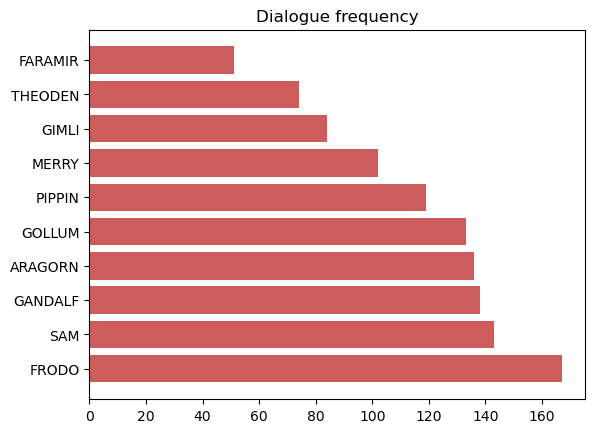

In [3]:
# Plotting dialouge frequnecy
char_freq = train_df.groupby("char").size().reset_index(name="freq")
char_freq = char_freq.sort_values(by="freq",ascending=False)
plt.barh(char_freq.char[:10], char_freq.freq[:10], color="indianred")
plt.title("Dialogue frequency")
plt.show()

In [4]:
stopwords_set = set(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm")

def simple_features(data: pd.DataFrame):
    # dialog lengths
    data["word_len"] = data.dialog.apply(lambda x: len(x.split()))
    data["character_len"] = data.dialog.apply(lambda x: len(x))
    # Stopword count
    data["stopword_count"] = data.dialog.apply(lambda x: sum(1 for word in x.split() if word.lower() in stopwords_set))
    # Word frequency by POS Tag
    data['verb_count'] = data['dialog'].apply(count_verbs)
    data['adj_count'] = data['dialog'].apply(count_adjectives)
    data['propn_count'] = data['dialog'].apply(count_proper_noun)
    # Uniqe word counter
    data['uinque_words'] = data['dialog'].apply(unique_words)

    return data

def count_verbs(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "VERB")

def count_adjectives(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "ADJ")

def count_proper_noun(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "PROPN")

def unique_words(text):
    return len(set(text.split()))


train_A = simple_features(train_df)
val_A = simple_features(val_df)
test_A = simple_features(test_df)

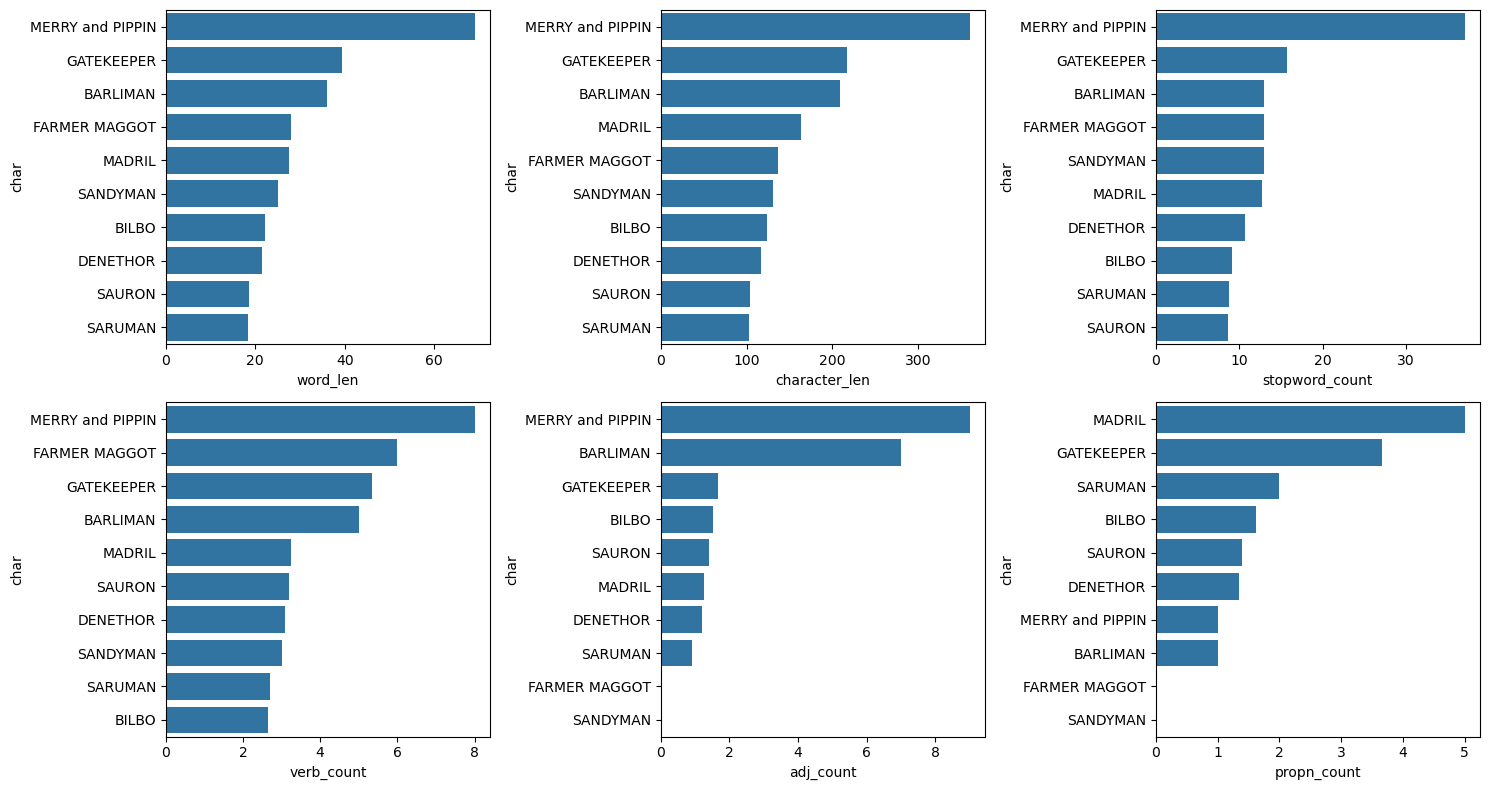

In [5]:
# Plotting dialouge frequnecy
char_var = train_A.groupby("char")[["word_len", "character_len", "stopword_count", "verb_count", "adj_count", "propn_count"]].mean().reset_index()
#char_var = char_var.sort_values(by="freq",ascending=False)

plt.figure(figsize = (15, 8))
plt.tight_layout()
plt.subplot(2, 3, 1)
char_var = char_var.sort_values(by="word_len", ascending=False)[:10]
sns.barplot(x=char_var.word_len, y=char_var.char)
plt.subplot(2, 3, 2)
char_var = char_var.sort_values(by="character_len", ascending=False)[:10]
sns.barplot(x=char_var.character_len, y=char_var.char)
plt.subplot(2, 3, 3)
char_var = char_var.sort_values(by="stopword_count", ascending=False)[:10]
sns.barplot(x=char_var.stopword_count, y=char_var.char)
plt.subplot(2, 3, 4)
char_var = char_var.sort_values(by="verb_count", ascending=False)[:10]
sns.barplot(x=char_var.verb_count, y=char_var.char)
plt.subplot(2, 3, 5)
char_var = char_var.sort_values(by="adj_count", ascending=False)[:10]
sns.barplot(x=char_var.adj_count, y=char_var.char)
plt.subplot(2, 3, 6)
char_var = char_var.sort_values(by="propn_count", ascending=False)[:10]
sns.barplot(x=char_var.propn_count, y=char_var.char)
plt.tight_layout()
plt.show()

## Sentiment Analysis

In [6]:
# Dialog sentiment
def word_sentiment_score(word: str) -> float:
    synsets = list(sentiwordnet.senti_synsets(word))
    if synsets:
        sentiment = synsets[0]
        return sentiment.pos_score() - sentiment.neg_score()
    else:
        return 0.0  

def sentence_sentiment(sentence):
    sent = nlp(sentence)
    sent_sentiment = sum(word_sentiment_score(token.text) for token in sent)
    return sent_sentiment

def dialog_sentiment(data):
    data['dialog_sentiment'] = data['dialog'].apply(sentence_sentiment)
    return data

train_A = dialog_sentiment(train_A)
val_A = dialog_sentiment(val_A)
test_A = dialog_sentiment(test_A)

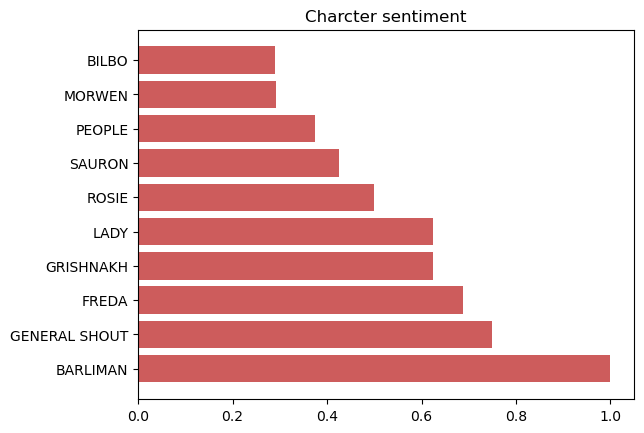

In [7]:
# Plotting dialouge frequnecy
char_sent = train_A.groupby("char")["dialog_sentiment"].mean().reset_index()
char_sent = char_sent.sort_values(by="dialog_sentiment", ascending=False)
plt.barh(char_sent.char[:10], char_sent.dialog_sentiment[:10], color="indianred")
plt.title("Charcter sentiment")
plt.show()

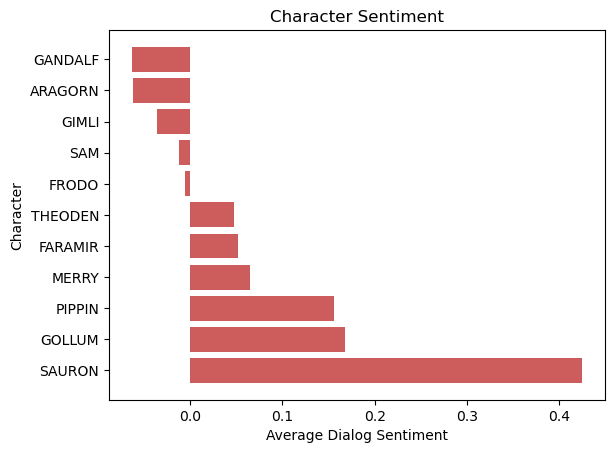

In [8]:
imp_char = ["FRODO", "SAM", "GANDALF", "PIPPIN", "MERRY", "GOLLUM", "GIMLI", "THEODEN", "FARAMIR", "SAURON", "ARAGORN"]

# Plotting dialouge frequnecy for characters of interest
char_sent = train_A.groupby("char")["dialog_sentiment"].mean().reset_index()
char_sent = char_sent.sort_values(by="dialog_sentiment", ascending=False)
char_sent_filtered = char_sent[char_sent['char'].isin(imp_char)]
plt.barh(char_sent_filtered['char'], char_sent_filtered['dialog_sentiment'], color="indianred")
plt.title("Character Sentiment")
plt.xlabel("Average Dialog Sentiment")
plt.ylabel("Character")
plt.show()

# LDA for Topic Analysis

In [9]:
# Topic modelling using LDA
stemmer = SnowballStemmer("english")


def stem(text):
    return stemmer.stem(text)

def preprocess_for_topic(document: str) -> List[str]:

    preprocessed = []
    for token in gensim.utils.simple_preprocess(document, min_len=4):
        if token not in stopwords_set: 
            preprocessed.append(stem(token.lower()))
    return preprocessed


def create_bow_corp(data):
    preprocessed = []
    [preprocessed.append(preprocess_for_topic(dialog)) for dialog in data.dialog]
    dic = corpora.Dictionary(preprocessed)
    bow_corpus = [dic.doc2bow(doc) for doc in preprocessed]
    return preprocessed, dic, bow_corpus

preprocessed_train, dic_train, bow_corpus_train = create_bow_corp(train_A)
preprocessed_val, dic_val, bow_corpus_val = create_bow_corp(val_A)
preprocessed_test, dic_test, bow_corpus_test = create_bow_corp(test_A)

In [10]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=42,
                                           chunksize=100,
                                           passes=10,)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocessed_train, dictionary=dic_train, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [11]:
# Finding Optimal Number of Topics
grid = {}
grid['Validation_Set'] = {}

topics_range = range(3, 11, 1)

model_results = {'Topics': [],
                 'Coherence': [] }

pbar = tqdm.tqdm(total=(len(topics_range)))
    
for k in topics_range:
    # get the coherence score for the given parameters
    cv = compute_coherence_values(corpus=bow_corpus_train, dictionary=dic_train, k=k)
    # Save the model results
    model_results['Topics'].append(k)
    model_results['Coherence'].append(cv)
                    
    pbar.update(1)
pd.DataFrame(model_results)
pbar.close()

100%|██████████| 8/8 [04:00<00:00, 30.02s/it]


In [12]:
# Her må du plotte et diagram elns
model_res = pd.DataFrame(model_results)
optimal_topics = model_res.loc[model_res['Coherence'].idxmax()]
print(optimal_topics)
model_res

Topics       10.000000
Coherence     0.493623
Name: 7, dtype: float64


,Topics,Coherence
0,3,0.384265
1,4,0.452236
2,5,0.476603
3,6,0.442785
4,7,0.470169
5,8,0.468070
6,9,0.475746
7,10,0.493623


In [13]:
lda_model_optimized = gensim.models.LdaMulticore(bow_corpus_train, num_topics = optimal_topics[0], id2word = dic_train, 
                                                 passes = 10, chunksize=100, random_state=42)

# Extract top contributing words for each topic
top_words_per_topic = []
for topic_id in range(lda_model_optimized.num_topics):
    topic_words = lda_model_optimized.show_topic(topic_id, topn=5)
    top_words = [word for word, _ in topic_words]
    top_words_per_topic.append(top_words)


for i, words in enumerate(top_words_per_topic):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: time, fight, gondor, must, speak
Topic 1: come, master, kill, need, king
Topic 2: gandalf, go, look, pippin, come
Topic 3: ring, know, must, mine, frodo
Topic 4: back, merri, death, good, give
Topic 5: mordor, never, frodo, make, road
Topic 6: dead, want, break, hand, littl
Topic 7: hobbit, could, would, gollum, someth
Topic 8: frodo, aragorn, take, lord, still
Topic 9: still, alway, tree, last, aragorn


In [14]:
def topic_predictions(bow_data, data):
    predictions = lda_model_optimized[bow_data]
    data["topic"] = [max(pred, key=lambda x: x[1])[0] for pred in predictions]
    return data

train_A = topic_predictions(bow_corpus_train, train_A)
val_A = topic_predictions(bow_corpus_val, val_A)
test_A = topic_predictions(bow_corpus_test, test_A)

In [15]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_optimized, bow_corpus_train, dictionary=lda_model_optimized.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.073188  0.021900       1        1  11.351886
1     -0.030336  0.141087       2        1  11.278263
2     -0.146702  0.053460       3        1  11.147016
3     -0.010441 -0.023570       4        1  10.776937
0      0.058195  0.006491       5        1  10.184553
7      0.059596 -0.139766       6        1  10.026709
9      0.054318  0.114714       7        1   9.494980
4     -0.211100 -0.092173       8        1   8.984385
5      0.069536  0.041093       9        1   8.692332
6      0.083746 -0.123238      10        1   8.062939, topic_info=        Term       Freq      Total Category  logprob  loglift
8      frodo  84.000000  84.000000  Default  30.0000  30.0000
72      come  95.000000  95.000000  Default  29.0000  29.0000
85   gandalf  45.000000  45.000000  Default  28.0000  28.0000
280     dead  24.000000  24.000000  Default  27.0000  27.0000
300     want  27.000000  27.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
150    river   3.765248  10.885173  Topic10  -5.0351   1.4563
62      ring   4.663187  45.013699  Topic10  -4.8212   0.2506
31      help   3.875495  15.788066  Topic10  -5.0062   1.1133
64    sauron   4.085740  25.870990  Topic10  -4.9534   0.6723
173     deep   3.578940  12.585628  Topic10  -5.0858   1.2604

[563 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1856      7  0.717557   aaaaagh
1790     10  0.806504    aaaahh
1748     10  0.806266   accomod
188       2  0.661114    across
188       9  0.165278    across
...     ...       ...       ...
106       6  0.318550     would
106       7  0.136521     would
106       8  0.022754     would
1818      3  0.871566     wrath
661       5  0.741214  yarvaxea

[966 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 3, 4, 1, 8, 10, 5, 6, 7])

## NRC Sentiment Analysis

In [16]:
file_path = 'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt' # path to downloaded lexicon file

def emotion_lexicon(file_path):
    lexicon_emotion = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            word, emotion, value = line.strip().split('\t')
            if int(value) == 1:
                if word not in lexicon_emotion:
                    lexicon_emotion.setdefault(word, []).append(emotion)
    return lexicon_emotion 


lexicon_emotion  = emotion_lexicon(file_path)

def emotion_counter(data):
    emotion_list = []

    for dialog in data.dialog:
        token_text = word_tokenize(dialog) # tokenize the text

        cleaned_text = [word for word in token_text if word not in stopwords_set] # remove stopwords
        emotion_counters = {emotion: 0 for emotions in lexicon_emotion.values() for emotion in emotions}
        for token in cleaned_text: # check every word in text
            if token in lexicon_emotion:
                token_emotions = lexicon_emotion[token]
                for emotion in token_emotions:
                    emotion_counters[emotion] += 1 
                

        emotion_list.append(emotion_counters)
    emotions_df = pd.DataFrame(emotion_list)
    
    data = pd.concat([data, emotions_df], axis=1)
    return data, emotions_df

train_A, emotions_df = emotion_counter(train_A)
val_A = emotion_counter(val_A)[0]
test_A = emotion_counter(test_A)[0]

emotions_df

,trust,fear,anger,positive,negative,disgust,surprise,joy,anticipation,sadness
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1667,0,0,2,0,0,0,0,0,0,0
1668,0,0,0,0,0,0,0,0,1,0
1669,0,0,0,0,0,0,0,0,0,0
1670,0,0,0,0,0,0,0,0,0,0


In [17]:
char_emot = train_A.groupby('char')[['trust', 'fear', 'negative', 'sadness', 'anger', 'surprise', 'positive', 
                                       'disgust', 'joy', 'anticipation']].sum().reset_index()
char_emot

,char,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation
0,ARAGORN,2,7,11,0,10,2,20,2,4,26
1,ARMY,0,0,0,0,0,0,0,0,0,0
2,ARWEN,1,1,4,0,3,0,2,0,0,7
3,BARLIMAN,0,0,1,0,0,0,2,0,0,1
4,BILBO,3,5,5,2,6,0,14,0,7,20
...,...,...,...,...,...,...,...,...,...,...,...
77,URUK-HAI,0,0,0,0,0,0,0,1,0,0
78,WHITE WIZARD,0,0,0,0,0,0,0,0,0,0
79,WILDMAN,0,1,0,0,1,0,0,0,0,0
80,WITCH KING,0,1,1,0,0,0,0,0,0,0


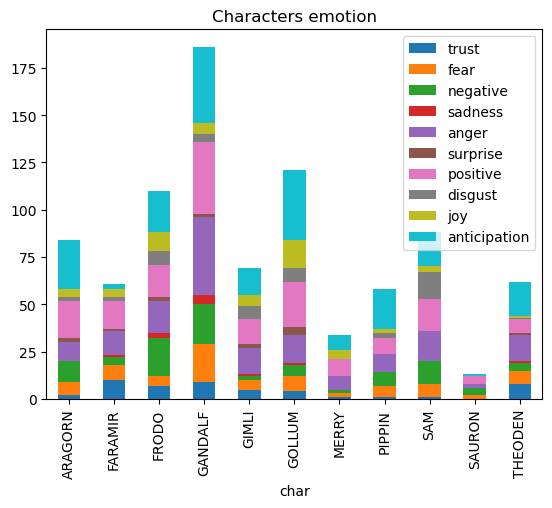

In [18]:
char_emot_filtered = char_emot[char_emot['char'].isin(imp_char)]

char_emot_filtered.plot(x='char', kind='bar', stacked=True,
        title='Characters emotion')
plt.show()

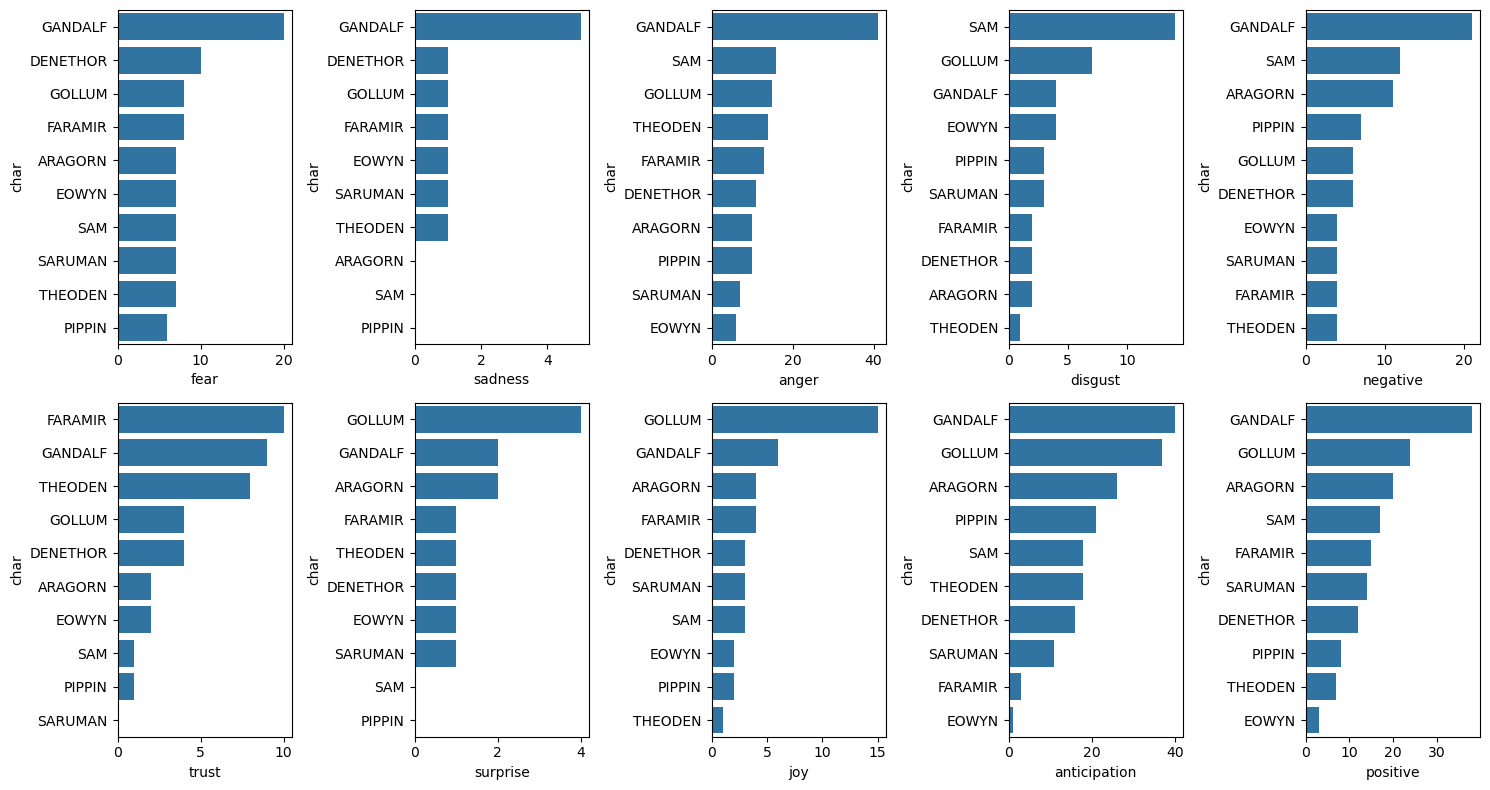

In [19]:
em_list = ['fear',  'sadness', 'anger', 'disgust', 'negative', 
           'trust', 'surprise',  'joy', 'anticipation', 'positive']

def char_emot_subplot(data, x):
    plt.figure(figsize = (15, 8))
    for i in range(1, len(x)+1):
        plt.subplot(2, 5, i)
        data = data.sort_values(by=x[i-1], ascending=False)[:10]
        sns.barplot(x=data[x[i-1]], y=data.char)
    plt.tight_layout()
    plt.show()

char_emot_subplot(char_emot, em_list)

## TF-IDF Dialog Scores 

In [20]:
def tf(document, term) -> float:

    term_freq = FreqDist()
    for word in document:
        if word.lower() == term:
            term_freq[term] += 1 
    
    return (term_freq[term])/len(document)


def idf(documents, term) -> float:

    doc_count = 0
    for doc in documents: 
        if term in doc:
            doc_count +=1
            
    if doc_count == 0:
        return 0 
        
    return np.log(len(documents)/(doc_count))


def tf_idf(all_documents, document, term) -> float:
    tf_idf = tf(document, term)*idf(all_documents, term)
    return tf_idf




def avg_tf_idf(data, preprocessed):
    dialog_avg_tfidf = []
    for dialog in preprocessed:
        score = 0
        for term in dialog:
            score += tf_idf(data.dialog, dialog, term)
        avg_tfidf = score/(len(dialog)+1)
        dialog_avg_tfidf.append(avg_tfidf)

    data["avg_tf-idf"] = dialog_avg_tfidf
    return data

train_A = avg_tf_idf(train_A, preprocessed_train)
val_A = avg_tf_idf(val_A, preprocessed_val)
test_A = avg_tf_idf(test_A, preprocessed_test)
train_A.head()

,char,dialog,word_len,character_len,stopword_count,verb_count,adj_count,propn_count,uinque_words,dialog_sentiment,...,fear,anger,positive,negative,disgust,surprise,joy,anticipation,sadness,avg_tf-idf
0,ORCS,"Grond, Grond, Grond, Grond!",4,29,0,0,0,4,2,0.000,...,0,0,0,0,0,0,0,0,0,0.000000
1,FRODO,Smeagol?,1,10,0,0,0,0,1,0.000,...,0,0,0,0,0,0,0,0,0,0.000000
2,SAM,Look!The gate.It's opening!I can see a way down.,8,49,2,1,0,0,8,0.125,...,0,0,0,0,0,0,0,0,0,1.286746
3,PIPPIN,"Well, that's good news.",4,24,0,0,1,0,4,0.500,...,0,0,0,0,0,0,0,1,0,1.231094
4,PIPPIN,Frodo.,1,11,0,0,0,1,1,0.000,...,0,0,0,0,0,0,0,0,0,0.000000


In [21]:
def common_label_removal(data):
    mask = data["char"].isin(imp_char)
    data.loc[~ mask, "char"] = "Rest"
    mask2 = data['char'] == 'Rest'
    data = data[~mask2]
    return data

train_A = common_label_removal(train_A).reset_index(drop=True).iloc[:,2:]
val_A = common_label_removal(val_A).reset_index(drop=True).iloc[:,2:]
test_A = common_label_removal(test_A).reset_index(drop=True).iloc[:,2:]

train_A.to_csv('train_A.csv', index=False)
val_A.to_csv('val_A.csv', index=False)
test_A.to_csv('test_A.csv', index=False)